# Personalized Medicine: Redefining Cancer Treatment Project
### Objective : Develop an algorithm to classify genetic mutations based on clinical evidence


### Team Member : Arun, Shivani, Thrang

## Business Understanding
In recent years, there has been considerable discussion about the transformative potential of precision medicine, particularly in the realm of genetic testing and its impact on disease treatment.

One key challenge in this domain is the extensive manual effort involved in interpreting genetic information, particularly in the context of cancer. Tumor sequencing often reveals a multitude of genetic mutations, numbering in the thousands. The critical task at hand is to differentiate between mutations that drive tumor growth (known as "drivers") and those that are inconsequential (referred to as "passengers").

Presently, this interpretation of genetic mutations relies heavily on manual review by clinical pathologists. This painstaking process involves scrutinizing each genetic variation and classifying it based on evidence extracted from text-based clinical literature.

Efforts are underway to address this challenge through the development of machine learning algorithms. These algorithms aim to utilize existing knowledge bases as a foundation to automatically classify genetic variations. Notably, Memorial Sloan Kettering Cancer Center (MSKCC) initiated a Kaggle competition centered on this very problem, seeking innovative solutions to automate the classification of genetic mutations.

The model built must be interpretable, as it will help the pathologist to make better decisions. Since one misinterpretations can cost a patient his/her life, the error cost is very high, Hence the model we build must be very accurate.

## Data Overview
*Source* : https://www.kaggle.com/c/msk-redefining-cancer-treatment/

There are nine different classes a genetic mutation can be classified on.

This is not a trivial task since interpreting clinical evidence is very challenging even for human specialists. Therefore, modeling the clinical evidence (text) will be critical for the success of your approach.

Both, training and test, data sets are provided via two different files. One (training/test_variants) provides the information about the genetic mutations, whereas the other (training/test_text) provides the clinical evidence (text) that our human experts used to classify the genetic mutations. Both are linked via the ID field.

#### Feature Description:
1. ID - Simple indexing given to data.
2. Gene - The Gene where the particular genetic mutation is located.
3. Variation - The change in the mutations.
4. Class - The class the genetic mutation belongs to.
5. Text (in training_text file) - The clinical text used to classify the genetic mutation.

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [44]:
df =pd.read_csv("/content/drive/MyDrive/Dataset/data.csv")  #loading the dataset

## Basic Checks

In [45]:
df.head(15)

,Unnamed: 0,ID,Gene,Variation,Class,Text
0,0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...
5,5,5,CBL,V391I,4,Oncogenic mutations in the monomeric Casitas B...
6,6,6,CBL,V430M,5,Oncogenic mutations in the monomeric Casitas B...
7,7,7,CBL,Deletion,1,CBL is a negative regulator of activated recep...
8,8,8,CBL,Y371H,4,Abstract Juvenile myelomonocytic leukemia (JM...
9,9,9,CBL,C384R,4,Abstract Juvenile myelomonocytic leukemia (JM...


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3321 entries, 0 to 3320
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  3321 non-null   int64 
 1   ID          3321 non-null   int64 
 2   Gene        3321 non-null   object
 3   Variation   3321 non-null   object
 4   Class       3321 non-null   int64 
 5   Text        3316 non-null   object
dtypes: int64(3), object(3)
memory usage: 155.8+ KB


In [47]:
df.describe(include="O")

,Gene,Variation,Text
count,3321,3321,3316
unique,264,2996,1920
top,BRCA1,Truncating Mutations,The PTEN (phosphatase and tensin homolog) phos...
freq,264,93,53


In [48]:
df.columns

Index(['Unnamed: 0', 'ID', 'Gene', 'Variation', 'Class', 'Text'], dtype='object')

In [49]:
df.Class.unique()

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [50]:
df["Class"].value_counts()

7    953
4    686
1    568
2    452
6    275
5    242
3     89
9     37
8     19
Name: Class, dtype: int64

In [51]:
df.duplicated().sum()   #checking for duplicates

0

# EDA

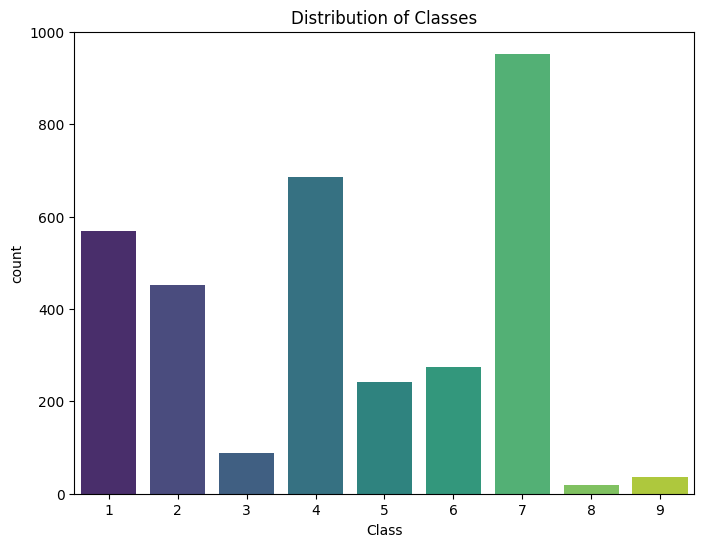

In [52]:
plt.figure(figsize=(8, 6))
sns.countplot(x='Class', data=df, palette='viridis')
plt.title('Distribution of Classes')
plt.show()

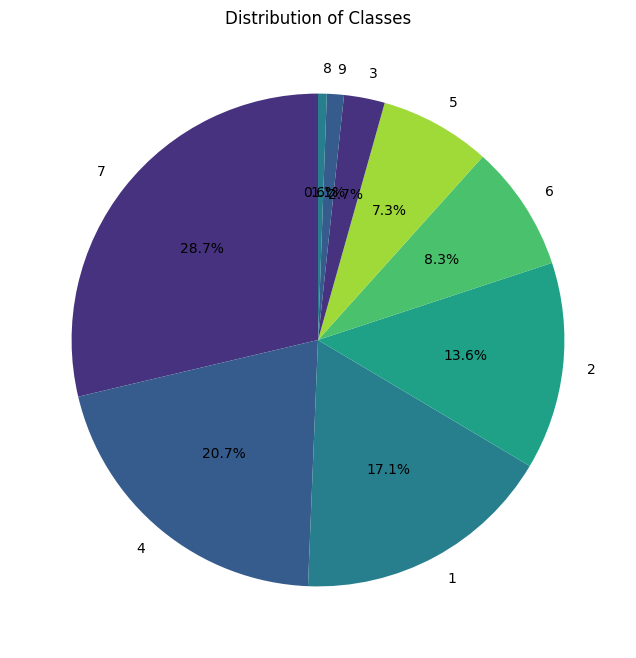

In [53]:
plt.figure(figsize=(8, 8))
df['Class'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis'))
plt.title('Distribution of Classes')
plt.ylabel('')  # To remove the default 'Class' label
plt.show()

## Data Preprocessing

In [54]:
df.loc[df['Text'].isnull(),'Text']  #The columns with null values

1109    NaN
1277    NaN
1407    NaN
1639    NaN
2755    NaN
Name: Text, dtype: object

In [55]:
df.loc[df['Text'].isnull(),'Text'] = df['Gene'] +' '+df['Variation']  # Fill the null values

In [56]:
df['Text'].iloc[2755]  #checking

'BRAF G596C'

In [57]:
df.drop(['Unnamed: 0','ID'],axis=1,inplace=True)  # Dropping the unnecessary columns

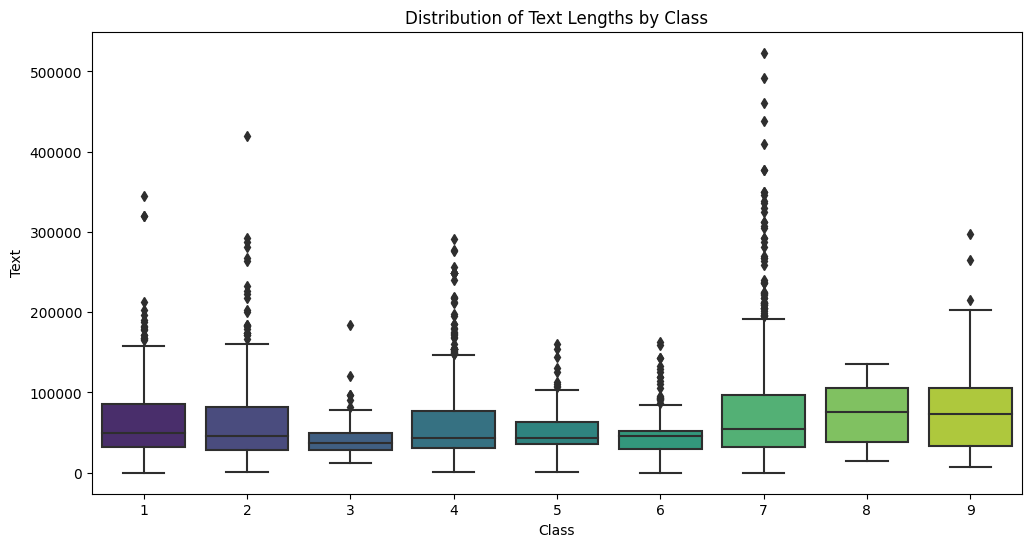

In [58]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y=df['Text'].apply(len), data=df, palette='viridis')
plt.title('Distribution of Text Lengths by Class')
plt.show()

In [59]:
# for text data
#Importing Libraries
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

In [60]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [61]:
#stopwords
stop_words = set(stopwords.words('english'))

In [62]:
def preprocess_text(text):
    text = str(text)
    text = text.lower() #Converting to lowercase
    #removing punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ',text)
    text = re.sub('<.*?>+',' ',text) #removing HTML Tags
    text = re.sub('[^a-zA-Z0-9\n]', ' ', text) #replacing special character with space
    text = re.sub(r'\s+', ' ',text) #removal of multiple spaces

    text_tokens = word_tokenize(text)

    #removing stopwords
    tw = [word for word in text_tokens if word not in stop_words]
    text = (" ").join(tw)
    return text

In [63]:
df['Text'] = df['Text'].apply(preprocess_text)  # applying the function to clean the text

In [64]:
#Replacing the excess space for Gene and variation
df['Gene'] = df['Gene'].str.replace('\s+', '_')
df['Variation'] = df['Variation'].str.replace('\s+', '_')

In [65]:
#Checking if the text have multiple space

def has_multiple_spaces(text):
    # Search for two or more consecutive spaces
    return bool(re.search('\s{2,}', text))


for i in range(len(df)):
    if has_multiple_spaces(df['Text'].iloc[i]):
        print("Text has multiple spaces.")
    else:
        pass



In [66]:
df['Text'].iloc[0] #checking the preprocess data

'cyclin dependent kinases cdks regulate variety fundamental cellular processes cdk10 stands one last orphan cdks activating cyclin identified kinase activity revealed previous work shown cdk10 silencing increases ets2 v ets erythroblastosis virus e26 oncogene homolog 2 driven activation mapk pathway confers tamoxifen resistance breast cancer cells precise mechanisms cdk10 modulates ets2 activity generally functions cdk10 remain elusive demonstrate cdk10 cyclin dependent kinase identifying cyclin activating cyclin cyclin orphan cyclin product fam58a whose mutations cause star syndrome human developmental anomaly whose features include toe syndactyly telecanthus anogenital renal malformations show star syndrome associated cyclin mutants unable interact cdk10 cyclin silencing phenocopies cdk10 silencing increasing c raf conferring tamoxifen resistance breast cancer cells cdk10 cyclin phosphorylates ets2 vitro cells positively controls ets2 degradation proteasome ets2 protein levels increa

### Splitting into Dependent and Independent Variables

In [67]:
X = df[['Gene', 'Variation', 'Text']]
y = df['Class']



In [68]:
from sklearn.model_selection import train_test_split
X_train_df,X_test_df, y_train, y_test = train_test_split(X, y, test_size= 0.25, stratify = y, random_state = 21)


In [69]:
!pip install category_encoders

In [70]:
import pandas as pd
import category_encoders as ce


# Initialize TargetEncoder
target_encoder = ce.TargetEncoder(cols=['Gene'])
target_encoder1 = ce.TargetEncoder(cols=['Variation'])

In [71]:
# performing the target encoding values to the 'genes' column
X_train_df['gene_target_encoded'] = target_encoder.fit_transform(X_train_df['Gene'], y_train)
X_test_df['gene_target_encoded'] = target_encoder.transform(X_test_df['Gene'], y_test)

In [72]:
# performing the target encoding values to the 'variation column' column
X_train_df['variation_target_encoded'] = target_encoder1.fit_transform(X_train_df['Variation'], y_train)
X_test_df['variation_target_encoded'] = target_encoder1.transform(X_test_df['Variation'], y_test)

In [73]:
#dropping the unnecessary columns and rows
X_train_data = X_train_df.drop(['Gene', 'Variation'], axis = 1)
X_test_data = X_test_df.drop(['Gene', 'Variation'], axis = 1)


In [74]:
#splitting all the columns
X_train_text = X_train_data['Text']
X_test_text = X_test_data['Text']
vectorizer = TfidfVectorizer(min_df = 3)  #applying vectorizer to text
X_train_text_vectorized = vectorizer.fit_transform(X_train_text)
X_test_text_vectorized = vectorizer.transform(X_test_text)

In [75]:
train_text_df = pd.DataFrame(X_train_text_vectorized.toarray(), columns=vectorizer.get_feature_names_out())  #converting to pandas dataframe
test_text_df = pd.DataFrame(X_test_text_vectorized.toarray(), columns=vectorizer.get_feature_names_out())  #converting to pandas dataframe

In [76]:
#concate the whole dataframe for the X_data
X_tem = X_train_data[['gene_target_encoded', 'variation_target_encoded']].reset_index(drop = True)
X_tem_test = X_test_data[['gene_target_encoded', 'variation_target_encoded']].reset_index(drop = True)
X_train = pd.concat([train_text_df, X_tem], axis=1)
X_test = pd.concat([test_text_df, X_tem_test], axis=1)

## Building a Machine Learning Model

In [77]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer, recall_score, log_loss


# Define the parameters for the grid search
param_grid = {
    'n_estimators': [100, 200, 300],  # Different number of trees
    'max_depth': [None, 5, 10, 15],   # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4]     # Minimum number of samples required at each leaf node
}

# Create a Random Forest Classifier instance
rf = RandomForestClassifier(random_state=42)

# Define scoring metrics (recall and neg_log_loss)
scoring = {
    'Recall': make_scorer(recall_score),
    'Log_Loss': make_scorer(log_loss, greater_is_better=False, needs_proba=True)
}

# Perform GridSearchCV with cross-validation using the specified scoring metrics
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=scoring, refit='Recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Retrieve the best parameters and best scores for Recall and Log Loss
best_params = grid_search.best_params_
best_recall = grid_search.best_score_
best_log_loss = grid_search.cv_results_['mean_test_Log_Loss'][grid_search.best_index_]

print("Best Parameters:", best_params)
print("Best Recall:", best_recall)
print("Best Log Loss:", best_log_loss)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model on the test set
test_accuracy = best_rf_model.score(X_test, y_test)
print("Test Accuracy of Best Model:", test_accuracy)


Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Recall: nan
Best Log Loss: -1.4728871785843598
Test Accuracy of Best Model: 0.6353790613718412


In [37]:
#svc
from sklearn.svm import SVC
SVM_class = SVC(C=100, gamma=1,random_state =42,probability=True)
SVM_class.fit(X_train, y_train)
y_pred_svc = SVM_class.predict(X_test)
y_pred_proba_svc = SVM_class.predict_proba(X_test)
print('Recall score : ', recall_score(y_test, y_pred_svc, average='weighted'))
print('f1 score : ', f1_score(y_test, y_pred_svc, average='weighted'))
print('log loss : ', log_loss(y_test, y_pred_proba_svc))

Recall score :  0.3574007220216607
f1 score :  0.31509349884461096
log loss :  2.287404241799407


In [38]:
#Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
RF_classifier = RandomForestClassifier(n_estimators = 1000, random_state =42, min_samples_split = 2, min_samples_leaf = 1, n_jobs = -1)
RF_classifier.fit(X_train, y_train)
y_pred_rf = RF_classifier.predict(X_test)
y_pred_proba_rf = RF_classifier.predict_proba(X_test)
print('Recall score : ', recall_score(y_test, y_pred_rf, average='weighted'))
print('f1 score : ', f1_score(y_test, y_pred_rf, average='weighted'))
print('log loss : ', log_loss(y_test, y_pred_proba_rf))

Recall score :  0.6486161251504212
f1 score :  0.6343165762786254
log loss :  1.746141273664571


In [78]:
#Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
RF_classifier = RandomForestClassifier(random_state = 42, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 100)
RF_classifier.fit(X_train, y_train)
y_pred_rf = RF_classifier.predict(X_test)
y_pred_proba_rf = RF_classifier.predict_proba(X_test)
print('Recall score : ', recall_score(y_test, y_pred_rf, average='weighted'))
print('f1 score : ', f1_score(y_test, y_pred_rf, average='weighted'))
print('log loss : ', log_loss(y_test, y_pred_proba_rf))

Recall score :  0.6353790613718412
f1 score :  0.6241422981673992
log loss :  2.339665867190205
